In [1]:
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Flatten, GlobalMaxPooling1D, LSTM, GRU, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_percentage_error


In [2]:
T = 128
Ntrain = 7352
Ntest = 2947
D = 9 # 9 files
K = 6 # 6 Classes


def load_data():
    # returns:
    # Xtrain (Ntrain x T x D), Ytrain (Ntrain)
    # Xtest (Ntest x T x D), Ytest (Ntest)
    
    Xtrain = np.zeros((Ntrain, T, D))
    Xtest = np.zeros((Ntest, T, D))
    
    
    
    ##### train data
    ts_filenames = [
        'body_acc_x_train.txt', 'body_gyro_x_train.txt', 'total_acc_x_train.txt',
        'body_acc_y_train.txt', 'body_gyro_y_train.txt', 'total_acc_y_train.txt',
        'body_acc_z_train.txt', 'body_gyro_z_train.txt', 'total_acc_z_train.txt'
    ]
    
    ts_file_prefix = '../Data/UCI HAR Dataset/train/'
    
    for d, fn in enumerate(ts_filenames):
        df = pd.read_csv(
            f'{ts_file_prefix}Inertial Signals/{fn}',
            header = None,
            delim_whitespace = True
        )
        
        # Ntrain x T array
        x = df.to_numpy()
        Xtrain[:, :, d] = x
        
    
    # train labels
    Ytrain = pd.read_csv(
        f'{ts_file_prefix}y_train.txt',
            header = None).to_numpy() -1
    Ytrain = Ytrain.flatten()
    
    
    
    ##### test data
    ts_filenames = [
        'body_acc_x_test.txt', 'body_gyro_x_test.txt', 'total_acc_x_test.txt',
        'body_acc_y_test.txt', 'body_gyro_y_test.txt', 'total_acc_y_test.txt',
        'body_acc_z_test.txt', 'body_gyro_z_test.txt', 'total_acc_z_test.txt'
    ]
    ts_file_prefix = '../Data/UCI HAR Dataset/test/'

    for d, fn in enumerate(ts_filenames):
        df = pd.read_csv(
            f'{ts_file_prefix}Inertial Signals/{fn}',
            header = None,
            delim_whitespace = True
        )
        
        # Ntest x T array
        x = df.to_numpy()
        Xtest[:, :, d] = x
        
    # test labels
    Ytest = pd.read_csv(
        f'{ts_file_prefix}y_test.txt',
            header = None).to_numpy() -1
    Ytest = Ytest.flatten()
    
    
    return Xtrain, Ytrain, Xtest, Ytest

In [3]:
Xtrain, Ytrain, Xtest, Ytest = load_data()

# LSTM model

In [4]:
# Make an RNN
i = Input(shape = (T, D))
x = LSTM(32, return_sequences = True)(i)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)

model = Model(i, x)

2023-10-02 12:54:32.904382: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-10-02 12:54:32.904416: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-10-02 12:54:32.904426: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-10-02 12:54:32.904468: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-02 12:54:32.904486: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
# To save the best model
check_point = ModelCheckpoint(
    'best_model.h5', monitor = 'val_loss', save_best_only = True)


In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 9)]          0         
                                                                 
 lstm (LSTM)                 (None, 128, 32)           5376      
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                                 
Total params: 5574 (21.77 KB)
Trainable params: 5574 (21.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
model.compile(
    loss = SparseCategoricalCrossentropy(from_logits = True),
    optimizer = 'adam',
    metrics = ['accuracy']
)

r = model.fit(
    Xtrain,
    Ytrain,
    epochs = 100,
    validation_data = (Xtest, Ytest)
    )

Epoch 1/100


2023-10-02 12:54:39.276450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


230/230 [==============================] - 11s 24ms/step - loss: 1.0302 - accuracy: 0.7101 - val_loss: 0.5408 - val_accuracy: 0.8911
Epoch 2/100
230/230 [==============================] - 3s 13ms/step - loss: 0.3372 - accuracy: 0.9100 - val_loss: 0.3684 - val_accuracy: 0.8802
Epoch 3/100
230/230 [==============================] - 3s 13ms/step - loss: 0.2391 - accuracy: 0.9199 - val_loss: 0.2888 - val_accuracy: 0.8911
Epoch 4/100
230/230 [==============================] - 3s 13ms/step - loss: 0.1801 - accuracy: 0.9365 - val_loss: 0.2981 - val_accuracy: 0.8985
Epoch 5/100
230/230 [==============================] - 3s 13ms/step - loss: 0.1479 - accuracy: 0.9464 - val_loss: 0.2855 - val_accuracy: 0.8989
Epoch 6/100
230/230 [==============================] - 3s 13ms/step - loss: 0.1443 - accuracy: 0.9431 - val_loss: 0.3142 - val_accuracy: 0.8789
Epoch 7/100
230/230 [==============================] - 3s 13ms/step - loss: 0.1311 - accuracy: 0.9427 - val_loss: 0.2447 - val_accuracy: 0.8979
Epo

KeyboardInterrupt: 

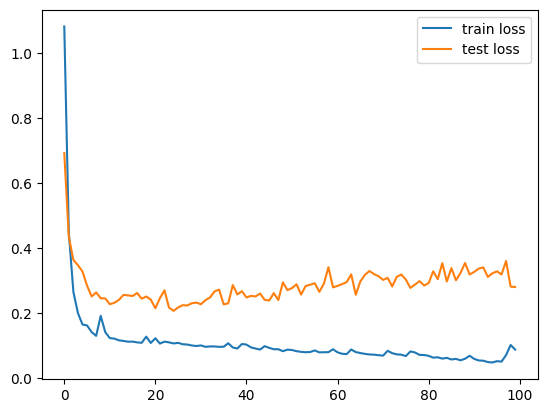

In [22]:
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'test loss')
plt.legend();

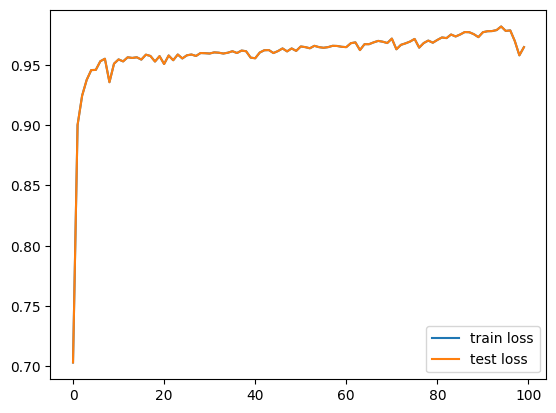

In [23]:
plt.plot(r.history['accuracy'], label = 'train loss')
plt.plot(r.history['accuracy'], label = 'test loss')
plt.legend();

In [26]:
# Load the best model
best_model = tf.keras.models.load_model('best_model.h5')

# make predictions
Ptest = best_model.predict(Xtest)

# evauluate
np.mean(np.argmax(Ptest, axis = 1) == Ytest)

93/93 [==============================] - 1s 4ms/step


0.9226331862911435

In [29]:
def load_features():
    df = pd.read_csv(
        '../Data/UCI HAR Dataset/train/X_train.txt',
        header = None,
        delim_whitespace = True
    )
    
    feat_train = df.to_numpy()
    
    # test data
    df = pd.read_csv(
        '../Data/UCI HAR Dataset/test/X_test.txt',
        header = None,
        delim_whitespace = True
    )
    feat_test = df.to_numpy()
    
    scaler = StandardScaler()
    feat_train = scaler.fit_transform(feat_train)
    feat_test = scaler.transform(feat_test)
    
    return feat_train, feat_test


feat_train, feat_test = load_features()

D_feat = feat_train.shape[1]

# Combined RNN

In [48]:
# Make an RNN
i = Input(shape = (T, D))
x = LSTM(32, return_sequences = True)(i)
x = GlobalMaxPooling1D()(x)

# ANN
i2 = Input(shape = (D_feat,))
x2 = Dense(32, activation = 'relu')(i2)

x = Concatenate()([x, x2])
x = Dense(K)(x)

model = Model([i, i2], x)

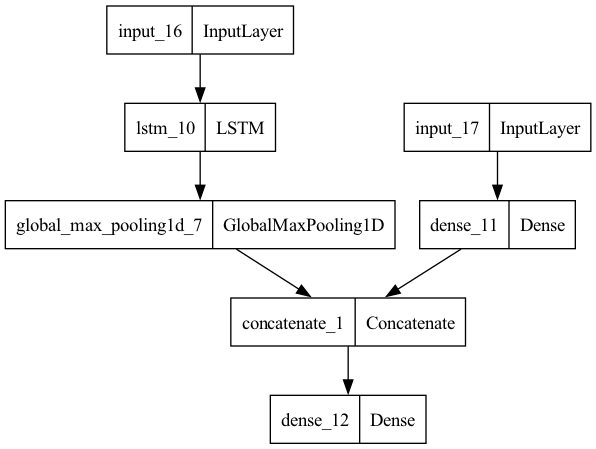

In [49]:
tf.keras.utils.plot_model(model)

In [58]:
# To save the best model
check_point = ModelCheckpoint(
    'best_model_combined.h5', monitor = 'val_accuracy', save_best_only = True)

In [59]:
model.compile(
    loss = SparseCategoricalCrossentropy(from_logits = True),
    optimizer = 'adam',
    metrics = ['accuracy']
)

r = model.fit(
    [Xtrain, feat_train],
    Ytrain,
    epochs = 15,
    callbacks = [check_point],
    validation_data = ([Xtest, feat_test], Ytest)
    )

Epoch 1/15
230/230 [==============================] - 7s 26ms/step - loss: 0.0043 - accuracy: 0.9990 - val_loss: 0.2751 - val_accuracy: 0.9420
Epoch 2/15
230/230 [==============================] - 6s 25ms/step - loss: 0.0048 - accuracy: 0.9981 - val_loss: 0.2971 - val_accuracy: 0.9352
Epoch 3/15
230/230 [==============================] - 6s 25ms/step - loss: 0.0104 - accuracy: 0.9959 - val_loss: 0.2729 - val_accuracy: 0.9437
Epoch 4/15
230/230 [==============================] - 6s 26ms/step - loss: 0.0016 - accuracy: 0.9999 - val_loss: 0.2891 - val_accuracy: 0.9420
Epoch 5/15
230/230 [==============================] - 6s 25ms/step - loss: 9.5575e-04 - accuracy: 1.0000 - val_loss: 0.3073 - val_accuracy: 0.9444
Epoch 6/15
230/230 [==============================] - 6s 26ms/step - loss: 6.8207e-04 - accuracy: 1.0000 - val_loss: 0.2998 - val_accuracy: 0.9416
Epoch 7/15
230/230 [==============================] - 6s 26ms/step - loss: 5.5815e-04 - accuracy: 1.0000 - val_loss: 0.3067 - val_accu

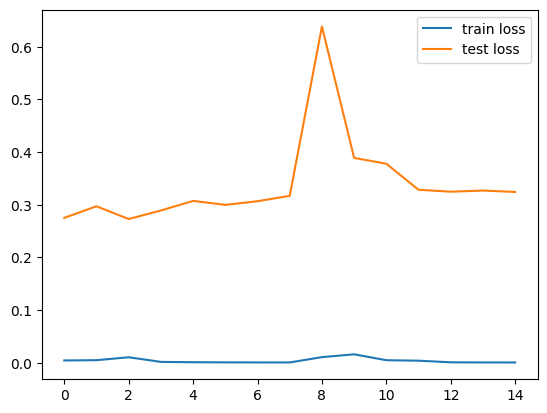

In [60]:
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'test loss')
plt.legend();

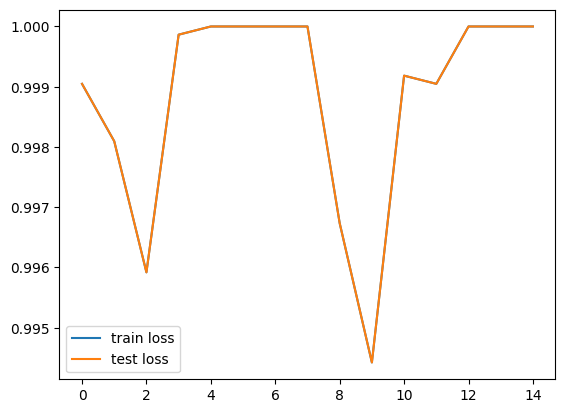

In [61]:
plt.plot(r.history['accuracy'], label = 'train loss')
plt.plot(r.history['accuracy'], label = 'test loss')
plt.legend();

In [62]:
# Load the best model
best_model = tf.keras.models.load_model('best_model_combined.h5')

# make predictions
Ptest = best_model.predict([Xtest, feat_test])

# evauluate
np.mean(np.argmax(Ptest, axis = 1) == Ytest.flatten())

93/93 [==============================] - 1s 6ms/step


0.9443501866304717